<a href="https://colab.research.google.com/github/clwilkinson7/Temp/blob/main/Week_11_DL7_2_dataaugmentation_Weekly_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Using data augmentation

In [1]:
from google.colab import files
uploaded = files.upload()

Saving Facial Recognition Dataset.zip to Facial Recognition Dataset.zip


In [10]:
try:
  !rm -rf /content/Facial\ Recognition\ Data\ Set/*
except:
  pass

!unzip -q Facial\ Recognition\ Dataset.zip

In [11]:
try:
  !rm -rf /content/Dataset/*
except:
  pass

!mkdir -p Dataset/Train/PersonA Dataset/Train/PersonB Dataset/Train/PersonC
!mkdir -p Dataset/Validation/PersonA Dataset/Validation/PersonB Dataset/Validation/PersonC
!mkdir -p Dataset/Test/PersonA Dataset/Test/PersonB Dataset/Test/PersonC

In [12]:
import os
import cv2

imagePaths = []
imageLabels = []
dataset = "Facial Recognition Dataset"

for label in os.listdir(dataset):
  labelPath = os.path.join(dataset, label)
  for imageName in os.listdir(labelPath):
      imagePath = os.path.join(labelPath, imageName)
      if imagePath.endswith((".bmp", ".gif", ".jpeg", ".jpg", ".png", ".JPG")):
        if imageName.endswith(".JPG"):
            newImagePath = imagePath[:-4] + ".jpg"
            os.rename(imagePath, newImagePath)
            imagePath = newImagePath
        else:
            imagePath = newImagePath

        imagePaths.append(imagePath)
        imageLabels.append(label)

In [13]:
from sklearn.model_selection import train_test_split

trainDataset, tempDataset, trainLabels, tempLabels = train_test_split(imagePaths, imageLabels, test_size=0.4, random_state=42, stratify=imageLabels)
validationDataset, testDataset, validationLabels, testLabels = train_test_split(tempDataset, tempLabels, test_size=0.5, random_state=42, stratify=tempLabels)

In [14]:
import shutil
from pathlib import Path

trainDir = Path("Dataset/Train/")
validationDir = Path("Dataset/Validation/")
testDir = Path("Dataset/Test/")

trainDirs = [str(dir) for dir in trainDir.iterdir()]
validationDirs = [str(dir) for dir in validationDir.iterdir()]
testDirs = [str(dir) for dir in testDir.iterdir()]


def ImageCopy(dataset, datasetDirs):
  for path in dataset:
    if os.path.isfile(path):
      label = os.path.basename(os.path.dirname(path))
      for dir in datasetDirs:
        if label == os.path.basename(dir):
          shutil.copy(path, dir)

ImageCopy(trainDataset, trainDirs)
ImageCopy(validationDataset, validationDirs)
ImageCopy(testDataset, testDirs)

In [15]:
import os, shutil

base_dir = 'Dataset'

train_dir = os.path.join(base_dir, 'Train')
validation_dir = os.path.join(base_dir, 'Validation')
test_dir = os.path.join(base_dir, 'Test')

train_Asa_dir = os.path.join(train_dir, 'Asa')
train_Beth_dir = os.path.join(train_dir, 'Beth')
train_Callum_dir = os.path.join(train_dir, 'Callum')

validation_Asa_dir = os.path.join(validation_dir, 'Asa')
validation_Beth_dir = os.path.join(validation_dir, 'Beth')
validation_Callum_dir = os.path.join(validation_dir, 'Callum')

test_Asa_dir = os.path.join(test_dir, 'Asa')
test_Beth_dir = os.path.join(test_dir, 'Beth')
test_Callum_dir = os.path.join(test_dir, 'Callum')

In [16]:
train_dir

'Dataset/Train'

In [17]:
from tensorflow.keras.utils import image_dataset_from_directory

imageSize = (180, 180)
batchSize = 8

trainDatasetBatched = image_dataset_from_directory(
    trainDir,
    image_size = imageSize,
    batch_size = batchSize,
)

validationDatasetBatched = image_dataset_from_directory(
    validationDir,
    image_size=imageSize,
    batch_size = batchSize,
)

testDatasetBatched = image_dataset_from_directory(
    testDir,
    image_size = imageSize,
    batch_size=batchSize,
)

Found 144 files belonging to 3 classes.
Found 48 files belonging to 3 classes.
Found 48 files belonging to 3 classes.


**Define a data augmentation stage to add to an image model**

In [18]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.2),
        layers.RandomTranslation(0.1,0.1,fill_mode="nearest",interpolation="bilinear")
    ]
)

**Displaying some randomly augmented training images**

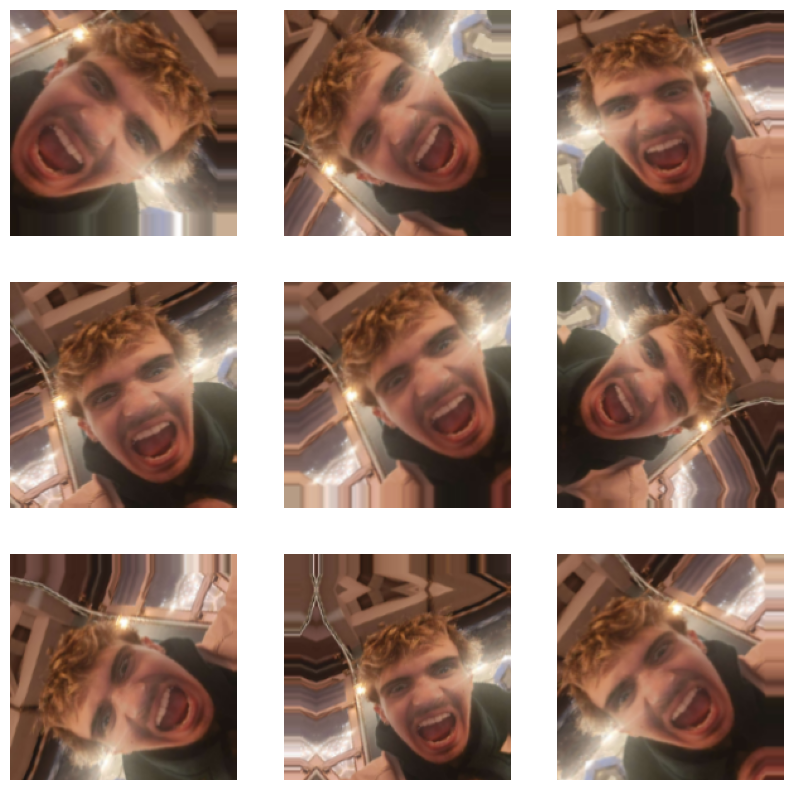

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, _ in trainDatasetBatched.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [21]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])


In [22]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 18, 18, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 9, 9, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 7, 7, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │          12,545 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 991,041 (3.78 MB)

 Trainable params: 991,041 (3.78 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    trainDatasetBatched,
    epochs=100,
    validation_data=validationDatasetBatched,
    callbacks=callbacks)

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step - accuracy: 0.3820 - loss: 1.2153 - val_accuracy: 0.3333 - val_loss: -0.4578
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 94ms/step - accuracy: 0.3109 - loss: 2.3590 - val_accuracy: 0.3333 - val_loss: -0.5001
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 0.3219 - loss: 0.5431 - val_accuracy: 0.3333 - val_loss: -0.2913
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy: 0.3535 - loss: 0.6958 - val_accuracy: 0.3333 - val_loss: -2.3415
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.3481 - loss: 4.6410 - val_accuracy: 0.3333 - val_loss: -1.9104
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.3495 - loss: 1.7553 - val_accuracy: 0.3333 - val_loss: -2.1520
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.3120 - loss: 2.2854 - val_accuracy: 0.3333 - val_loss: -17.6725
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.3669 - loss: 23.4149 - val_

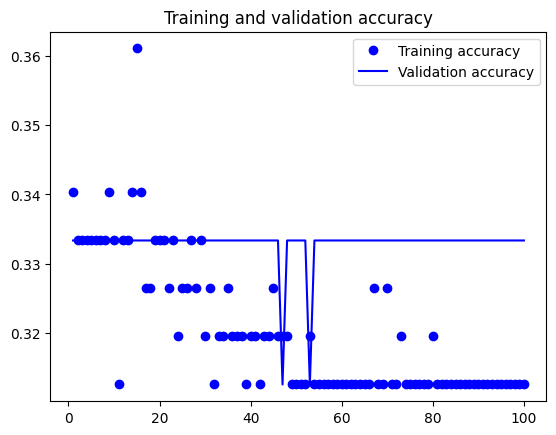

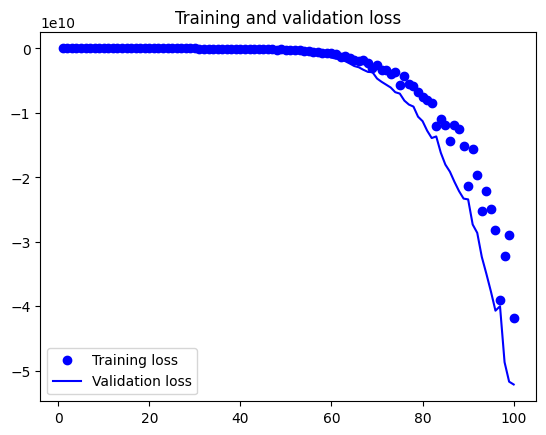

In [24]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [25]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(testDatasetBatched)
print(f"Test accuracy: {test_acc:.3f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.3024 - loss: -33139025920.0000
Test accuracy: 0.312
